In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # add parent directory to path

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 54
plt.rcParams['ytick.labelsize'] = 54

In [3]:
import torch

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from botorch.models import SingleTaskGP
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from gpytorch.kernels import MaternKernel, ScaleKernel
from botorch.utils.sampling import draw_sobol_samples
from botorch.sampling.pathwise import draw_kernel_feature_paths
from pandora_automl.utils import fit_gp_model
from pandora_automl.acquisition.log_ei_puc import LogExpectedImprovementWithCost
from pandora_automl.acquisition.gittins import GittinsIndex

In [5]:
def plot_posterior(ax, objective_function, model, test_x, train_x, train_y, next_points=None, maximize=False):
    with torch.no_grad():
        objective_y = objective_function(test_x.view(-1, 1)).detach().numpy()
        posterior = model.posterior(test_x.unsqueeze(-1).unsqueeze(-1))
        mean = posterior.mean.squeeze().cpu().numpy()
        lower, upper = posterior.mvn.confidence_region()
        lower, upper = lower.squeeze().cpu().numpy(), upper.squeeze().cpu().numpy()

        ax.plot(test_x.cpu().numpy(), objective_y, 'tab:grey', alpha=0.6, linewidth=5)
        ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*', alpha=0.8, markersize=48)
        best_idx = torch.argmax(train_y) if maximize else torch.argmin(train_y)
        # ax.plot(train_x[best_idx].cpu().numpy(), train_y[best_idx].cpu().numpy(), 'r*', markersize=48)
        ax.plot(test_x.cpu().numpy(), mean, color='blue', linewidth=5)
        ax.fill_between(test_x.cpu().numpy(), lower, upper, alpha=0.2, color='blue')

        if next_points:
            for point, color in next_points:
                ax.plot(point.item(), objective_function(point).item(), '.', color=color, markersize=54)


def plot_single_acquisition(ax, test_x, acq_values, point, label, color, horizontal_line=None, horizontal_label=None):
    ax.plot(test_x.numpy(), acq_values.detach().numpy(), linewidth=5)
    ax.plot(point[0].numpy(), point[1].detach().numpy(), '.', color=color, markersize=54, label="next point")

    if horizontal_line is not None:
        ax.axhline(horizontal_line, linestyle='--', color='grey', linewidth=5,
                   label=horizontal_label or f'Threshold ({horizontal_line:.2f})')

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=54)

In [6]:
# --- Setup ---
seed = 123
maximize = False
dim = 1
nu, lengthscale, outputscale = 2.5, 0.1, 1.0
noise_level = 1e-6
torch.manual_seed(seed)

# Set up kernel
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = lengthscale
base_kernel.raw_lengthscale.requires_grad = False
scale_kernel = ScaleKernel(base_kernel).double()
scale_kernel.outputscale = torch.tensor([[outputscale]])
scale_kernel.raw_outputscale.requires_grad = False

# Draw sample objective
model_dummy = SingleTaskGP(torch.empty(1, dim), torch.empty(1, 1),
                           likelihood=FixedNoiseGaussianLikelihood(noise=torch.ones(1) * noise_level),
                           covar_module=scale_kernel)
matern_sample = draw_kernel_feature_paths(model_dummy, sample_shape=torch.Size([1]))
def objective_function(x): return matern_sample(x).squeeze(0).detach()

# Generate initial data
bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])
x = draw_sobol_samples(bounds=bounds, n=1, q=4*(dim+1)).squeeze(0)
y = objective_function(x)
best_f = y.max().item() if maximize else y.min().item()
Yvar = torch.ones(len(x)) * noise_level
model = fit_gp_model(x, y, scale_kernel)

# Evaluation grid
test_x = torch.linspace(0, 1, 10001)

/Users/qianxie/Desktop/Curriculum/Graduate/Research/CostAwareStoppingBayesOpt/automl_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/CostAwareStoppingBayesOpt/automl_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1659]), std = tensor([0.9134])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


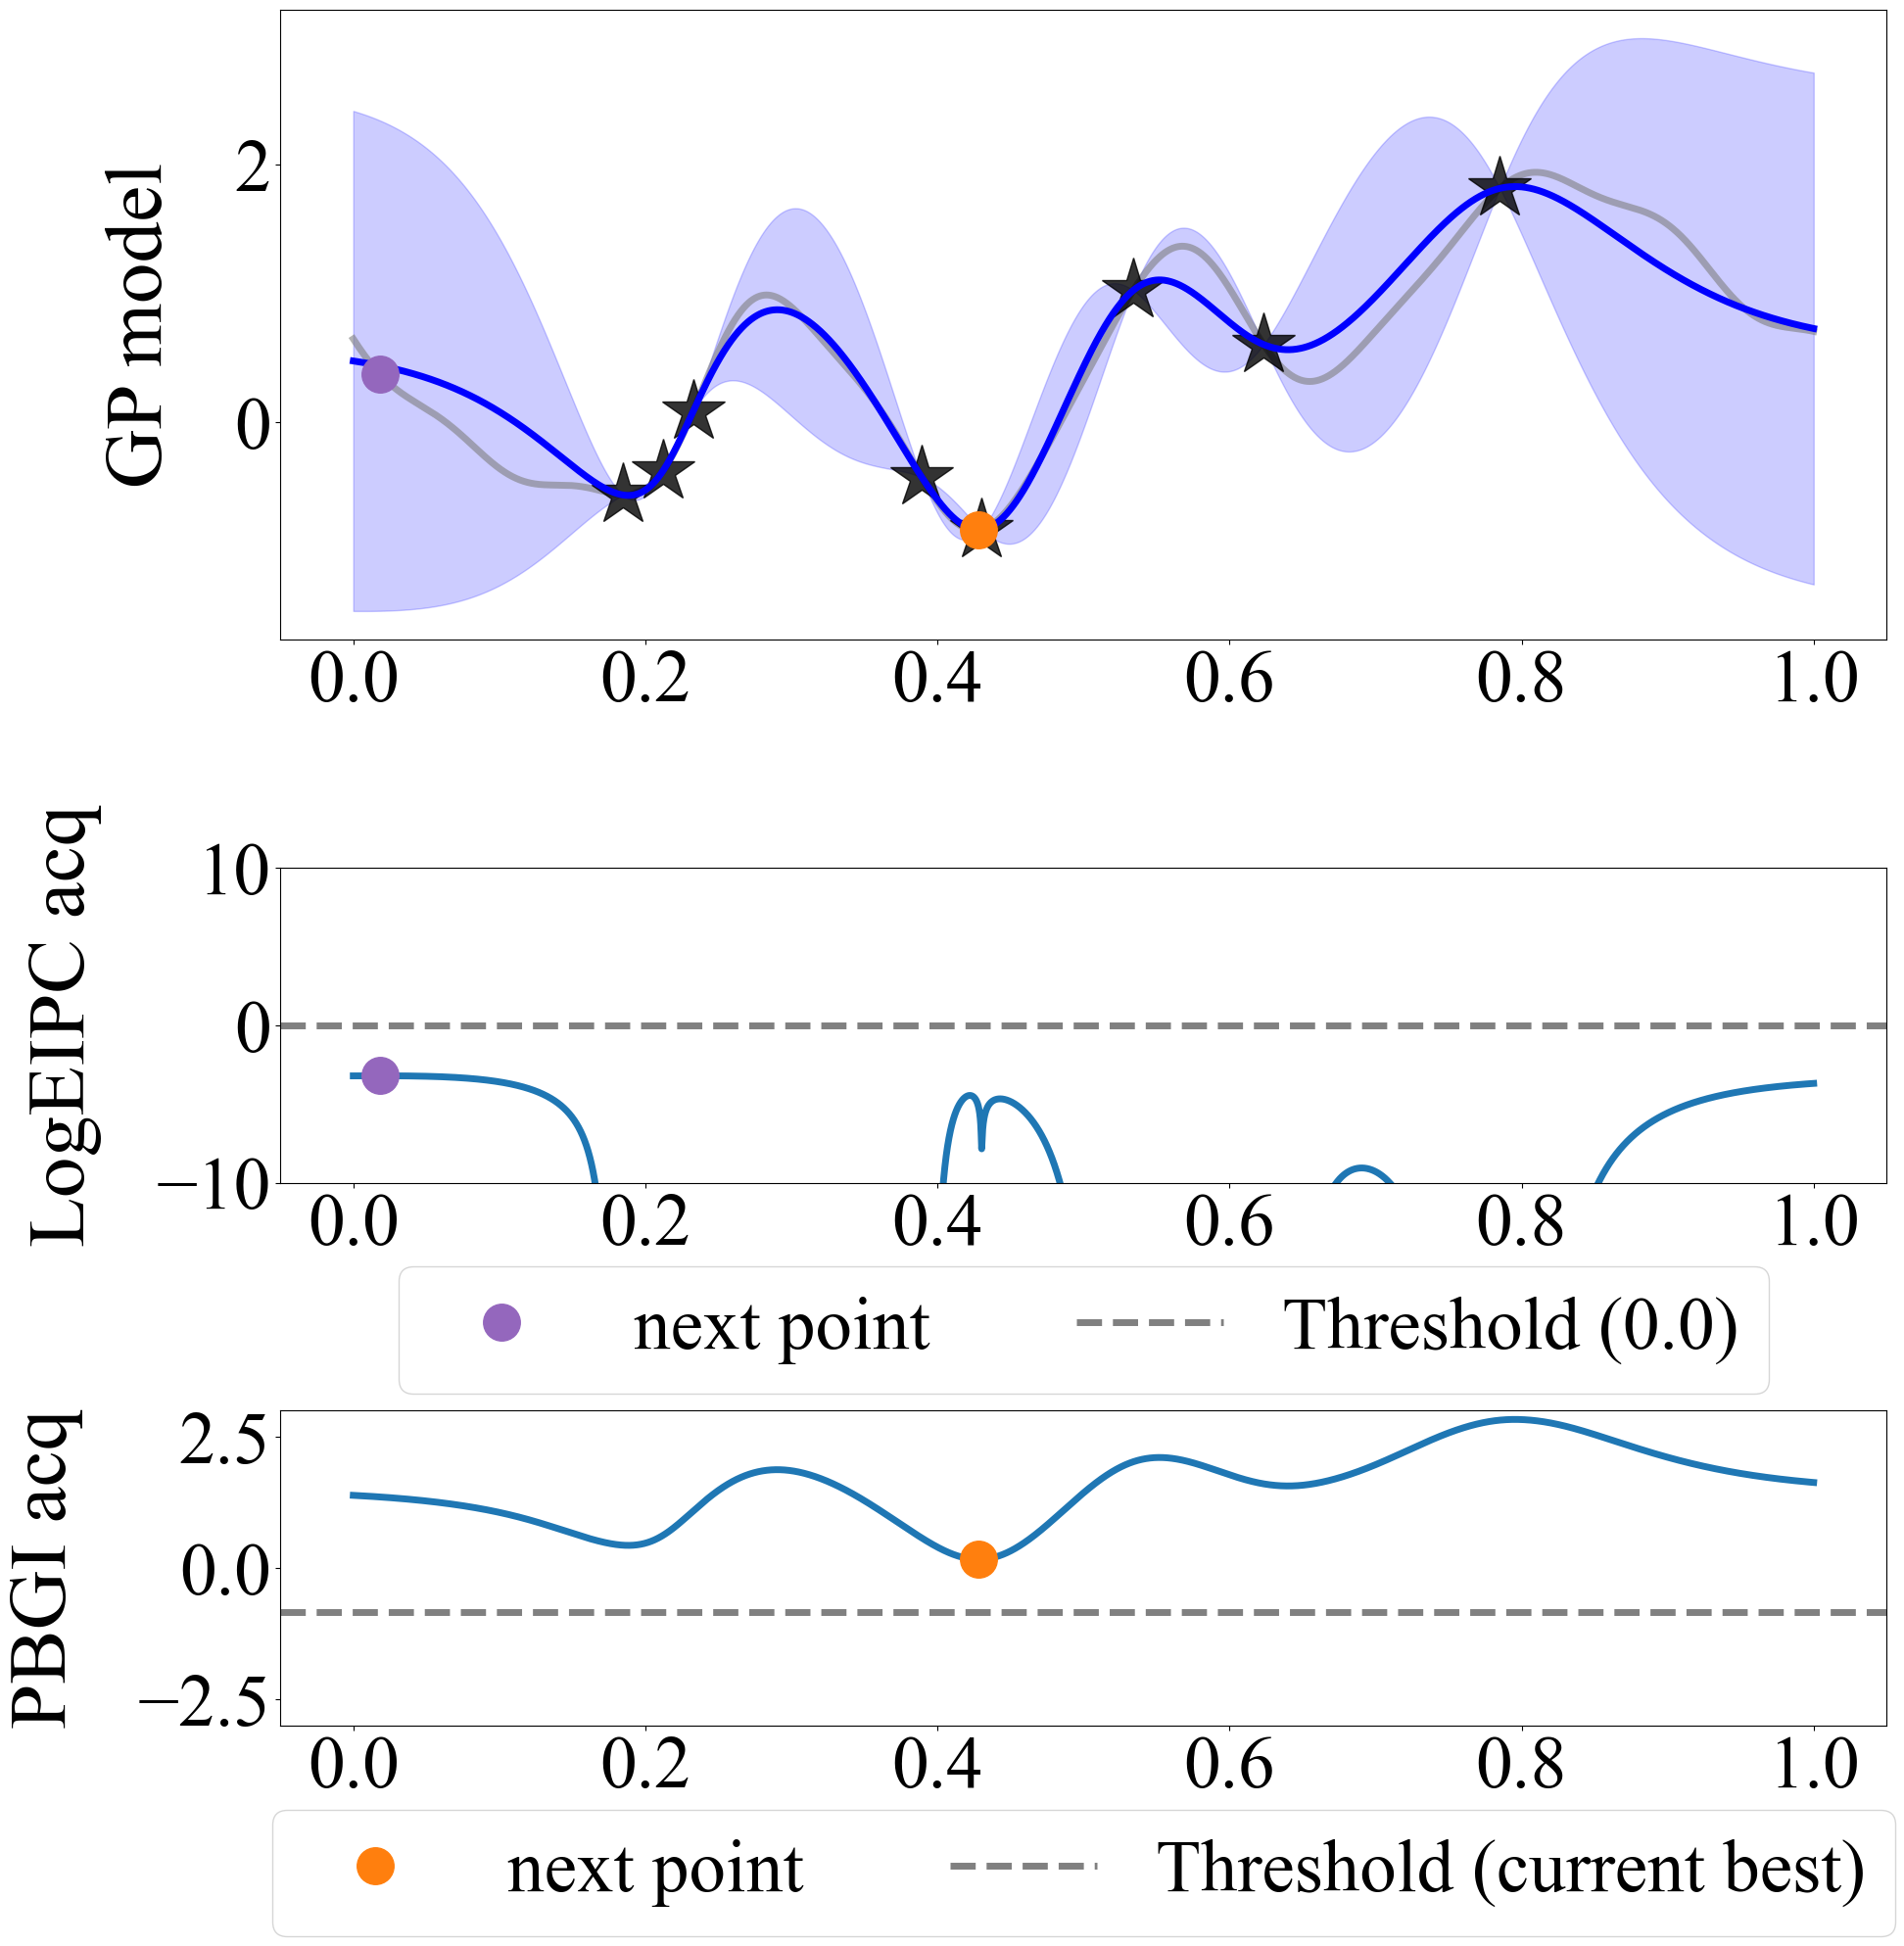

In [7]:
# LogEIPC
cost_fn = lambda X: torch.full(X.shape[:-1], 1.0, dtype=X.dtype)
LogEIPC = LogExpectedImprovementWithCost(model=model, best_f=best_f, maximize=maximize, cost=cost_fn)
acq_logei = LogEIPC.forward(test_x.unsqueeze(1).unsqueeze(1))
new_point_logei = test_x[torch.argmax(acq_logei)]
val_logei = torch.max(acq_logei)

# PBGI
GI = GittinsIndex(model=model, maximize=maximize, lmbda=1.0)
acq_pbgi = GI.forward(test_x.unsqueeze(1).unsqueeze(1))
new_point_pbgi = test_x[torch.argmin(acq_pbgi)]
val_pbgi = torch.min(acq_pbgi)

## --- Plotting ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20), gridspec_kw={'height_ratios': [2, 1, 1]})

# Posterior with both next query points, no legend
plot_posterior(
    ax1, objective_function, model, test_x, x, y,
    next_points=[
        (new_point_logei, 'tab:purple'),
        (new_point_pbgi, 'tab:orange')
    ],
    maximize=maximize
)

# LogEIPC acquisition: threshold = 0
plot_single_acquisition(
    ax2, test_x, acq_logei, (new_point_logei, val_logei),
    label='LogEIPC', color='tab:purple',
    horizontal_line=0.0, horizontal_label='Threshold (0.0)'
)
ax2.set_ylim(-10, 10)

# PBGI acquisition: threshold = current best
plot_single_acquisition(
    ax3, test_x, acq_pbgi, (new_point_pbgi, val_pbgi),
    label='PBGI', color='tab:orange',
    horizontal_line=best_f, horizontal_label='Threshold (current best)'
)
ax3.set_ylim(-3, 3)

ax1.set_ylabel('GP model', labelpad=40, fontsize=60, rotation='vertical')
ax2.set_ylabel('LogEIPC acq', labelpad=40, fontsize=60, rotation='vertical')
ax3.set_ylabel('PBGI acq', labelpad=40, fontsize=60, rotation='vertical')


plt.tight_layout()
plt.savefig('../plots/LogEIPC_vs_PBGI_acq_large.pdf', format='pdf')
plt.show()

In [8]:
# --- Setup ---
seed = 123
maximize = False
dim = 1
nu, lengthscale, outputscale = 2.5, 0.1, 1.0
noise_level = 1e-6
torch.manual_seed(seed)

# Set up kernel
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = lengthscale
base_kernel.raw_lengthscale.requires_grad = False
scale_kernel = ScaleKernel(base_kernel).double()
scale_kernel.outputscale = torch.tensor([[outputscale]])
scale_kernel.raw_outputscale.requires_grad = False

# Draw sample objective
model_dummy = SingleTaskGP(torch.empty(1, dim), torch.empty(1, 1),
                           likelihood=FixedNoiseGaussianLikelihood(noise=torch.ones(1) * noise_level),
                           covar_module=scale_kernel)
matern_sample = draw_kernel_feature_paths(model_dummy, sample_shape=torch.Size([1]))
def objective_function(x): return matern_sample(x).squeeze(0).detach()

# Generate initial data
bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])
x = draw_sobol_samples(bounds=bounds, n=1, q=4*(dim+1)).squeeze(0)
y = objective_function(x)
best_f = y.max().item() if maximize else y.min().item()
Yvar = torch.ones(len(x)) * noise_level
model = fit_gp_model(x, y, scale_kernel)

# Evaluation grid
test_x = torch.linspace(0, 1, 10001)

/Users/qianxie/Desktop/Curriculum/Graduate/Research/CostAwareStoppingBayesOpt/automl_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/CostAwareStoppingBayesOpt/automl_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.1659]), std = tensor([0.9134])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


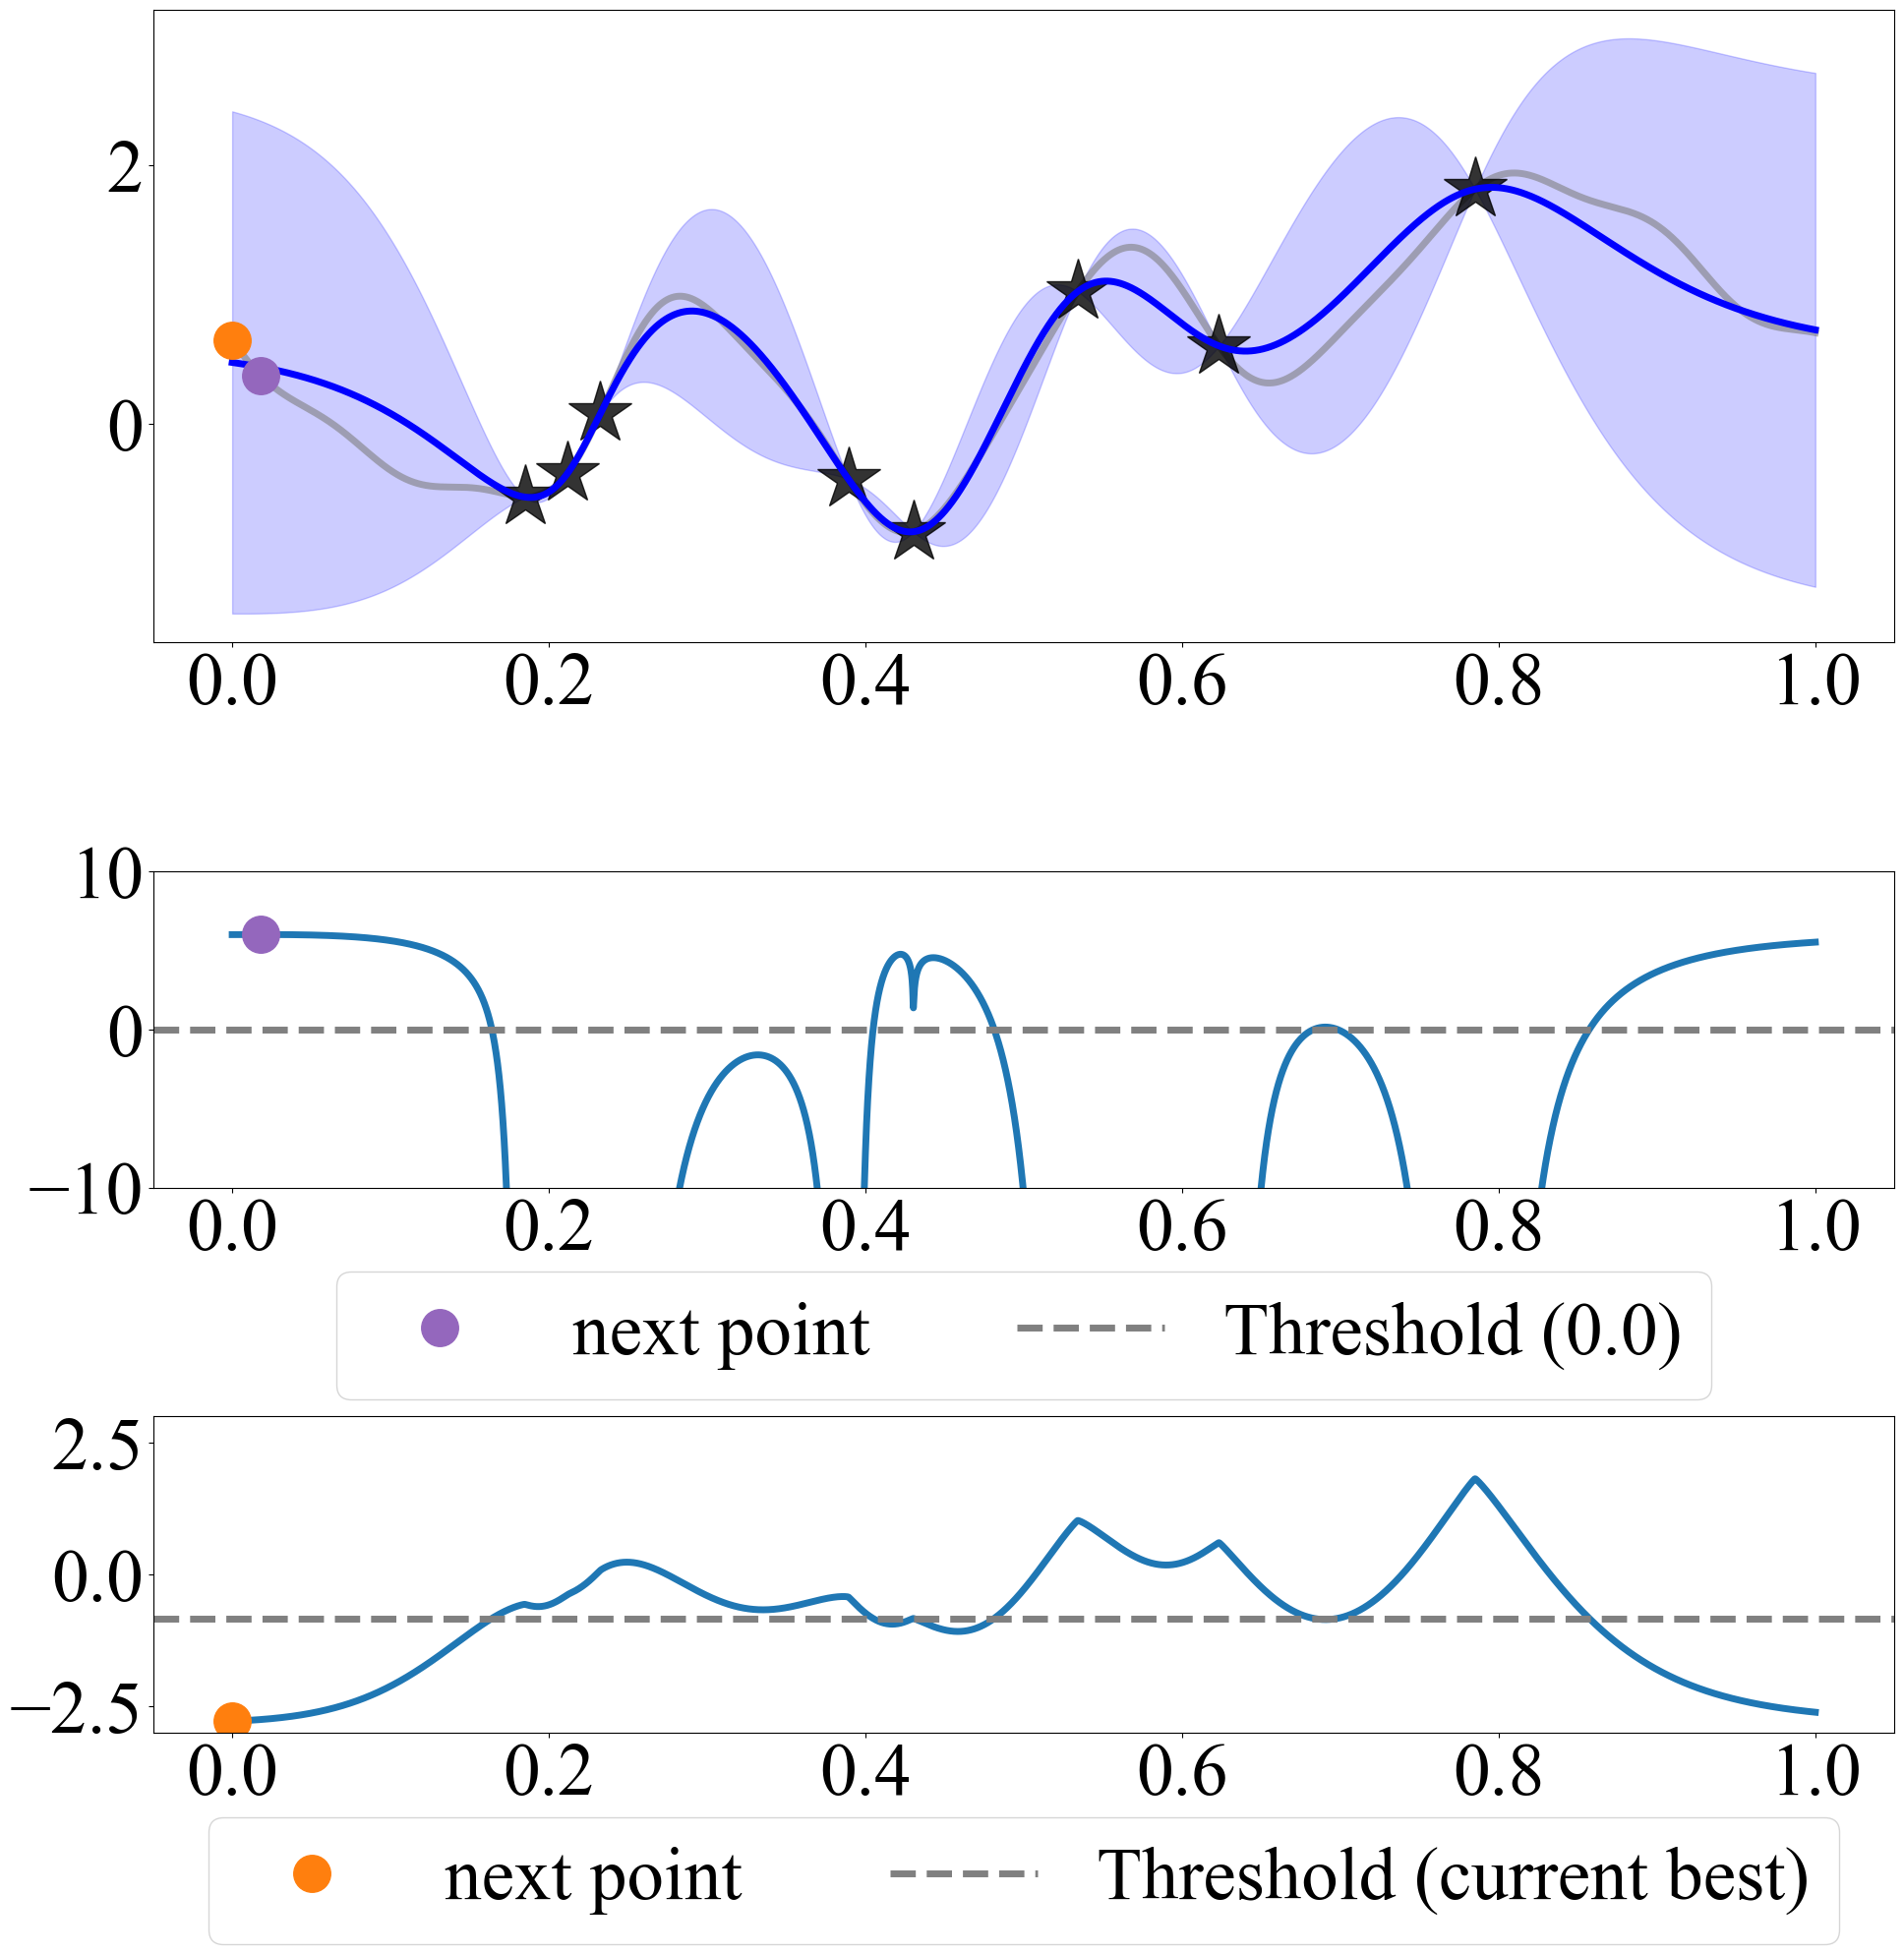

In [9]:
# LogEIPC
cost_fn = lambda X: torch.full(X.shape[:-1], 0.0001, dtype=X.dtype)
LogEIPC = LogExpectedImprovementWithCost(model=model, best_f=best_f, maximize=maximize, cost=cost_fn)
acq_logei = LogEIPC.forward(test_x.unsqueeze(1).unsqueeze(1))
new_point_logei = test_x[torch.argmax(acq_logei)]
val_logei = torch.max(acq_logei)

# PBGI
GI = GittinsIndex(model=model, maximize=maximize, lmbda=0.0001)
acq_pbgi = GI.forward(test_x.unsqueeze(1).unsqueeze(1))
new_point_pbgi = test_x[torch.argmin(acq_pbgi)]
val_pbgi = torch.min(acq_pbgi)

## --- Plotting ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20), gridspec_kw={'height_ratios': [2, 1, 1]})

# Posterior with both next query points, no legend
plot_posterior(
    ax1, objective_function, model, test_x, x, y,
    next_points=[
        (new_point_logei, 'tab:purple'),
        (new_point_pbgi, 'tab:orange')
    ],
    maximize=maximize
)

# LogEIPC acquisition: threshold = 0
plot_single_acquisition(
    ax2, test_x, acq_logei, (new_point_logei, val_logei),
    label='LogEIPC', color='tab:purple',
    horizontal_line=0.0, horizontal_label='Threshold (0.0)'
)
ax2.set_ylim(-10, 10)

# PBGI acquisition: threshold = current best
plot_single_acquisition(
    ax3, test_x, acq_pbgi, (new_point_pbgi, val_pbgi),
    label='PBGI', color='tab:orange',
    horizontal_line=best_f, horizontal_label='Threshold (current best)'
)
ax3.set_ylim(-3, 3)

plt.tight_layout()
plt.savefig('../plots/LogEIPC_vs_PBGI_acq_small.pdf', format='pdf')
plt.show()